# Ball Challenge

In [1]:


import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import functools
from utils import PositionPrediction

plt.style.use("seaborn-v0_8-whitegrid")

from elasticai.creator.file_generation.on_disk_path import OnDiskPath
from elasticai.creator.vhdl.system_integrations.firmware_env5 import FirmwareENv5

experiment = PositionPrediction()

## Load Training and Test Data

In [2]:

experiment.load_dataset()

print("Train Samples:", len(experiment.train_set))
print("Test Samples:", len(experiment.test_set))

print("Sample Shape:", experiment.input_shape)

Train Samples: 43
Test Samples: 14
Sample Shape: (3, 250)


## Create Model

In [22]:
def conv(in_channels, out_channels, kernel_size):
    return nn.Sequential(nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
                         nn.BatchNorm1d(num_features=out_channels),
                         nn.Sigmoid())

def create_model():
    return nn.Sequential(
    conv(3, 3, kernel_size=64),
    conv(3, 2, kernel_size=26),
    conv(2, 2, kernel_size=13),
    conv(2, 1, kernel_size=13),
    nn.Flatten(),
    nn.Linear(in_features=138, out_features=2)
)




## Train Model

In [20]:
experiment.model = create_model()
experiment.train(epochs=500)

epoch: 0, train loss: 0.02780562825500965, test loss: 0.04992453889281023
epoch: 1, train loss: 0.02711755409836769, test loss: 0.049973002406269576
epoch: 2, train loss: 0.0264847744256258, test loss: 0.0501527405743088
epoch: 3, train loss: 0.025903107598423958, test loss: 0.05043611196534974
epoch: 4, train loss: 0.025369875133037567, test loss: 0.050802392369535355
epoch: 5, train loss: 0.024883350357413292, test loss: 0.051231133086340766
epoch: 6, train loss: 0.024442074820399284, test loss: 0.051707372501758594
epoch: 7, train loss: 0.024044163525104523, test loss: 0.052219081769830415
epoch: 8, train loss: 0.023687072098255157, test loss: 0.05276137094811669
epoch: 9, train loss: 0.02336735837161541, test loss: 0.05331893777474761
epoch: 10, train loss: 0.02308070845901966, test loss: 0.053880703036806414
epoch: 11, train loss: 0.022822247818112373, test loss: 0.054452433749767284
epoch: 12, train loss: 0.022586829960346222, test loss: 0.055028306519878764
epoch: 13, train loss

## Training History and Distance from predicted positions

mean distance between predicted and actual position  0.9150558837822506  meters


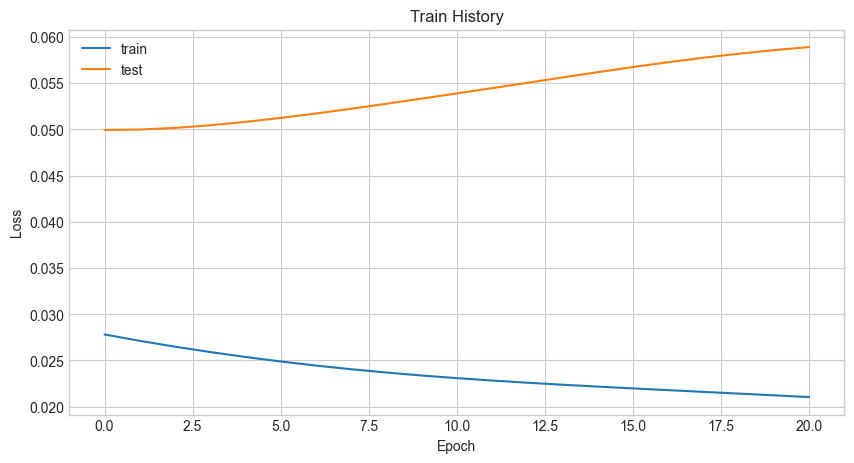

In [21]:
experiment.plot_history()
print("mean distance between predicted and actual position ", experiment.get_mean_and_var_distance_for_test()[0], " meters")

## Save Hardware Implementation

In [19]:
def save_hw_implementation():
    path = OnDiskPath("build")

    hw_design = experiment.model.create_design("ball_throw")

    channels, signal_length = experiment.input_shape
    total_length = channels * signal_length

    firmware = FirmwareENv5(
        network=hw_design,
        x_num_values=total_length,
        y_num_values=2,
        skeleton_version="v2",
        id=666
    )
    firmware.save_to(path)
    hw_design.save_to(path)